# Imputing Age

In [1]:
#load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

data_dir = 'data/'

data = pd.read_csv(data_dir + 'train.csv')
agena = data[data.Age.isnull()]
agedata = data[~data.Age.isnull()]
agedata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


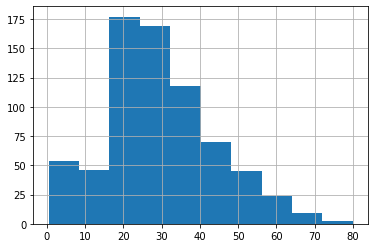

In [3]:
data.Age.hist()

### Note3:
I think number of siblings or parents/children can defintely tell something about the age group of a person. The remaining variables that make a little to no sense are {Pclass, sex, Fare}

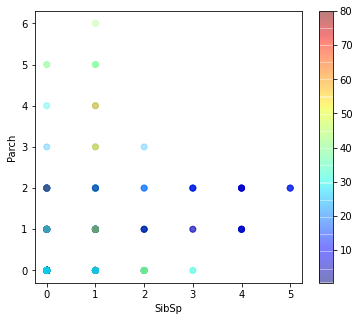

In [38]:
fig, ax = plt.subplots(figsize=(6,5))

ax.scatter(agedata.SibSp, agedata.Parch, c=agedata.Age, cmap=plt.get_cmap('jet'), alpha=0.3)
pcm = ax.get_children()[0]
ax.set_xlabel('SibSp')
ax.set_ylabel('Parch')
plt.colorbar(pcm, ax=ax)

In [37]:
print(sum(agedata.Age > 60))
print(agedata.shape)

22
(714, 12)


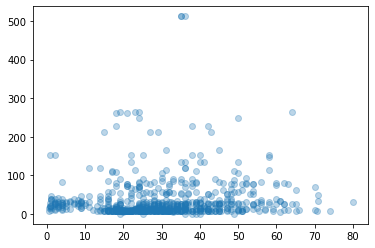

In [39]:
plt.scatter(agedata.Age, agedata.Fare, alpha=0.3)

In [3]:
# create data to train model
agedata = agedata[agedata.Age < 60]
X = agedata[['SibSp', 'Parch']]
X['high_fare'] = agedata.Fare > 200
y = agedata.Survived

In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

param_grid = [
    {'n_estimators': [100, 150, 200], 'max_depth': [2, 3], 'max_leaf_nodes': [4, 5, 6, 7]},
]

xgb = XGBRegressor()

grids = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", return_train_score=True, cv=5)
grids.fit(X, y)

joblib.dump(grids.best_estimator_, 'filename.pkl')

['filename.pkl']

In [18]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

xgb = XGBRegressor(max_depth=3, max_leaf_nodes=4, n_estimators=100)

scores = cross_val_score(xgb, X, y, cv=5, scoring='neg_mean_squared_error')
scores

array([-0.22731072, -0.23627792, -0.22221136, -0.22011519, -0.19503342])

-0.2201897205660109


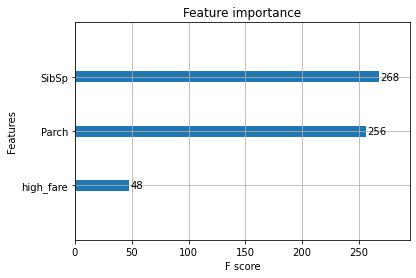

In [8]:
from xgboost import plot_importance

plot_importance(grids.best_estimator_)
print(grids.best_score_)

In [2]:
#create a function to name data frames

namedict = {'Pclass': ['1', '2', '3'], 
            'Sex': ['female', 'male'],
            'Cabin': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'],
            'Embarked': ['C', 'Q', 'S'],
            'Age': '.',
            'SibSp': '.',
            'Parch': '.',
            'Fare': '.',
            }

def col_names(features=[], extra = []):
    namelist = []
    for feature in features:
        for category in namedict[feature]:
            namelist.append(feature + '_' + category)
    namelist.extend(extra)
    return namelist

In [3]:
#load data
Pclass_ix = np.s_[:, 0:3]
Sex_ix = np.s_[:, 3:5]
Cabin_ix = np.s_[:, 5:14]
Embarked_ix = np.s_[:, 14:17]
Age_ix = np.s_[:, 17]
SibSp_ix = np.s_[:, 18]
Parch_ix = np.s_[:, 19]
Fare_ix = np.s_[:, 20]

clean_data = pd.read_csv(data_dir + 'halfclean.csv', index_col=0).to_numpy()

In [16]:
X = np.c_[clean_data[SibSp_ix], clean_data[Parch_ix], clean_data[Fare_ix], clean_data[Sex_ix],
            clean_data[Pclass_ix]]
y = clean_data[Age_ix]

nan_ix = np.isnan(y)
X = X[~nan_ix]
y = y[~nan_ix]

X = pd.DataFrame(X)
X.columns = col_names(features=['SibSp', 'Parch', 'Fare', 'Sex', 'Pclass'])

In [25]:
param_grid = [
    {'n_estimators': np.arange(8,15,step=1), 'max_depth': [2, 3, 4], 'max_leaf_nodes': [4, 5, 6, 7]},
]

grids_xgb_age = GridSearchCV(XGBRegressor(), param_grid, scoring="neg_mean_squared_error", return_train_score=True, cv=5)
grids_xgb_age.fit(X, y)

joblib.dump(grids_xgb_age.best_estimator_, 'xgb_best_age.pkl')
grids_xgb_age.best_params_

{'max_depth': 3, 'max_leaf_nodes': 4, 'n_estimators': 13}

-151.08696331701339


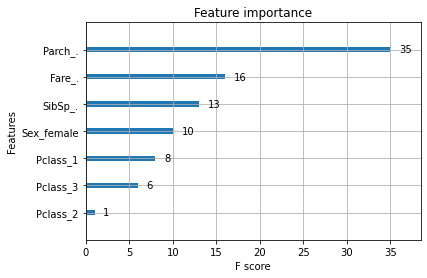

In [26]:
from xgboost import plot_importance

plot_importance(grids_xgb_age.best_estimator_)
print(grids_xgb_age.best_score_)

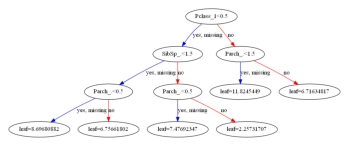

In [29]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
plot_tree(grids_xgb_age.best_estimator_, figsize=(7, 5))